Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


<Figure size 1152x864 with 0 Axes>

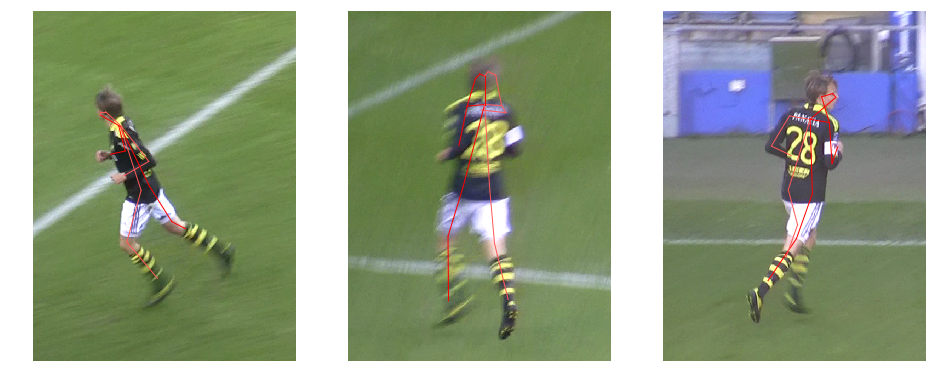

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
sys.path.insert(0,'../debugging')
import paf_loader
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth
from mvpose import pose
import paf_loader

from mvpose import settings

params = settings.get_settings(scale_to_mm=1000, max_epi_distance=20)

colors = cs.lincolor(20).astype('float32')/255
#FRAME = 40
FRAME = 5
tmp = Settings['tmp']
data_root = Settings['data_root']
# seq1_zipname = 'player1sequence2.zip'
# seq1_dir = 'Sequence 2'

seq1_zipname = 'player2sequence1.zip'
seq1_dir = 'Sequence 1'

Im, Calib, pos2d, pos3d = kth.get(data_root, seq1_zipname, seq1_dir, 
                                  FRAME)

from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d

# heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
#     'kth' + seq1_zipname[0:-4], Im, FRAME, dir=tmp)
# _start = time()
# Debug, detections = pose.estimate(Calib, heatmaps, pafs,
#                                   settings=params, debug=True)
# _end = time()
# print('elapsed', _end - _start)

from openpose import OpenPose
pe = OpenPose(tmp=tmp)

name = 'cvpr_kth_' + seq1_zipname
predictions = pe.predict(Im, name, FRAME)

Humans = predictions

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

fig = plt.figure(figsize=(16, 8))
for idx, (im, pred) in enumerate(zip(Im, predictions)):
    ax = fig.add_subplot(1, 3, idx+1); ax.axis('off')
    ax.imshow(im)
    
    for human in pred:
        draw_mscoco_human2d(ax, human[:, 0:2], color='red')

plt.show()

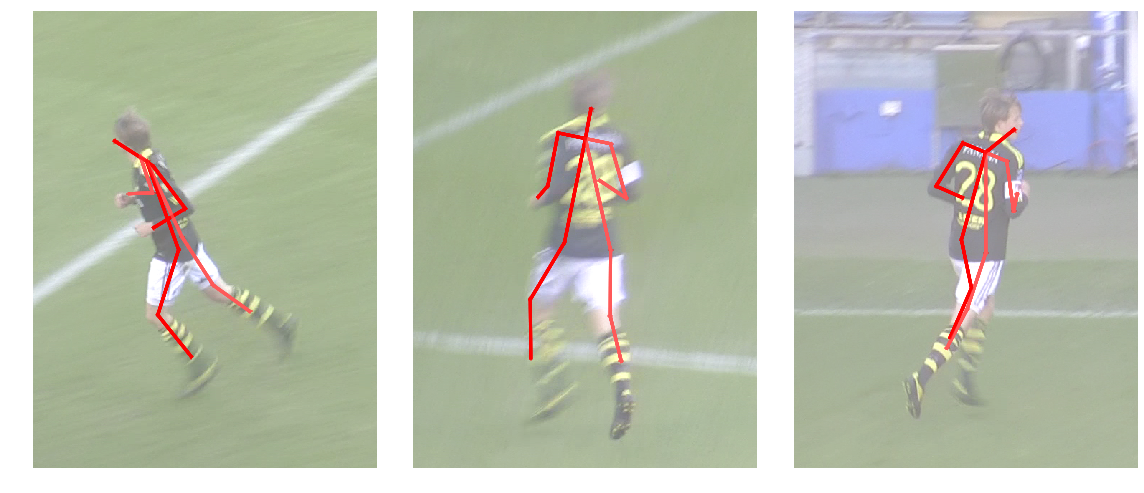

In [2]:
from mvpose.baseline.baseline import estimate

H, Hypothesis = estimate(Calib, predictions, 
                         epi_threshold=80,
                         scale_to_mm=1000,
                         get_hypothesis=True)

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green', 'teal']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3, 1+cid)
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(H):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5,
                          color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [3]:
A = np.array([1, 2, 3, 4, 5, 6])

lr = [1, 3]
rl = [3, 1]

A[lr] = A[rl]

A

array([1, 4, 3, 2, 5, 6])